In [ ]:
import nltk                                  # Python library for NLP
from nltk.corpus import twitter_samples      # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt              # visualization library
import numpy as np                           # library for scientific computing and matrix operations

In [ ]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [ ]:
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 

# download the stopwords for the process_tweet function
nltk.download('stopwords')

import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

tweets = all_positive_tweets + all_negative_tweets

In [ ]:
print(f'Ilość pozytywnych tweetów: {len(all_positive_tweets)}')
print(f'Ilość negatywnych tweetów: {len(all_negative_tweets)}')

Ilość pozytywnych tweetów: 5000
Ilość negatywnych tweetów: 5000


In [ ]:
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))

Dzielenie zbioru na treningowy (80%) i testowy (20%)


In [ ]:
train_pos = all_positive_tweets[:4000]
train_neg = all_negative_tweets[:4000]
test_pos = all_positive_tweets[4000:]
test_neg = all_negative_tweets[4000:]

X_train = train_pos + train_neg 
X_test = test_pos + test_neg

Tworzenie labelek pozytywnych i negatywnych



In [ ]:
y_train = np.concatenate([
    np.ones(len(train_pos)),
    np.zeros(len(train_neg))
])

y_test = np.concatenate([
    np.ones(len(test_pos)),
    np.zeros(len(test_neg))
])

In [ ]:
print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))

y_train.shape = (8000,)
y_test.shape = (2000,)


In [ ]:
X_train[:2]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!']

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
from spacy import displacy

## Normalizacja

In [ ]:
import re

def process_tweet(tweet):
   
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', ' ', tweet)
    
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', ' ', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', ' ', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    #remove username
    tweet = re.sub(r'@([A-Za-z]+[A-Za-z0-9]+)', ' ', tweet)

    tweet = re.sub(r'\n', ' ', tweet)
    
    tweet = tweet.replace('<br />', ' ')

    #to lower case
    tweet = tweet.lower()

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = ""
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean += str(stem_word)

    return tweet


X_train_norm = [process_tweet(x) for x in X_train]
X_test_norm = [process_tweet(x) for x in X_test]



In [ ]:
X_train_norm[:2]

['followfriday  _inte    _paris for being top engaged members in my community this week :)',
 '  hey james! how odd :/ please call our contact centre on 02392441234 and we will be able to assist you :) many thanks!']

In [ ]:
df_train = pd.DataFrame(
    {'X': X_train_norm, 'y':y_train.astype(int)}
)
df_train = df_train.sample(frac=1.0)
df_train

,X,y
643,brijresidency is a g+6 stories structure with ...,1
4764,_based is that you? what happened? :(,0
5246,"esnho: why the ""node15 - advanced directx11 sh...",0
490,thanks manthan! stay tuned with us :),1
3265,celebrate end of work week!:) invite your frie...,1
...,...,...
1184,"telling people at kfc to go buy ""she's kinda h...",1
6371,but why? :(,0
2284,my town's sister town :d,1
7110,my kik - gion886 kik kikhorny teens talk nsfw ...,0


In [ ]:
df_test = pd.DataFrame(
    {'X': X_test_norm, 'y':y_test.astype(int)}
)
# df_test = df_test.sample(frac=1.0)

##Wektoryzacja

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
vectorizer.fit(df_train['X'])

TfidfVectorizer(max_features=10000)

In [ ]:
X_train_vec = vectorizer.transform(df_train['X'])
X_train_vec

<8000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 67170 stored elements in Compressed Sparse Row format>

##Regresja logistyczna

In [ ]:
clf = LogisticRegression()
clf.fit(X_train_vec, df_train['y'])

LogisticRegression()

In [ ]:
y_train_pred = clf.predict(X_train_vec)

In [ ]:
y_train_pred

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Wyniki regresji logistycznej

In [ ]:
print('Train acc: ', accuracy_score(y_true=df_train['y'], y_pred=y_train_pred))
print('Train precision: ', precision_score(y_true=df_train['y'], y_pred=y_train_pred))
print('Train recall: ', recall_score(y_true=df_train['y'], y_pred=y_train_pred))


Train acc:  0.878
Train precision:  0.894572025052192
Train recall:  0.857


In [ ]:
X_test_vec = vectorizer.transform(X_test_norm)
y_test_pred = clf.predict(X_test_vec)

print('Test acc: ', accuracy_score(y_true=y_test, y_pred=y_test_pred))
print('Test precision: ', precision_score(y_true=y_test, y_pred=y_test_pred))
print('Test recall: ', recall_score(y_true=y_test, y_pred=y_test_pred))

Test acc:  0.7545
Test precision:  0.7763300760043431
Test recall:  0.715


##Tablica pomyłek

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from scikitplot.estimators import plot_feature_importances

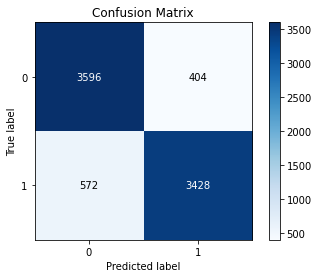

In [ ]:
plot_confusion_matrix(y_true=df_train['y'], y_pred=y_train_pred )

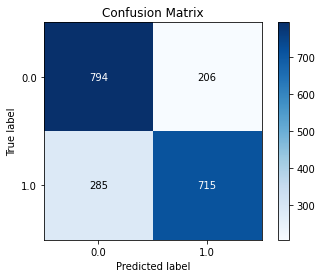

In [ ]:
plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred)

##Krzywa ROC

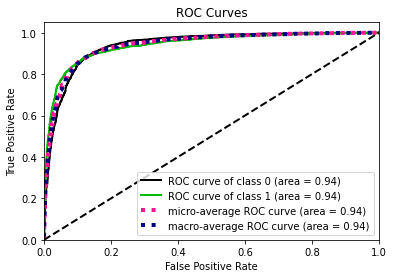

In [ ]:
y_train_proba = clf.predict_proba(X_train_vec)

plot_roc(y_true=df_train['y'], y_probas=y_train_proba)

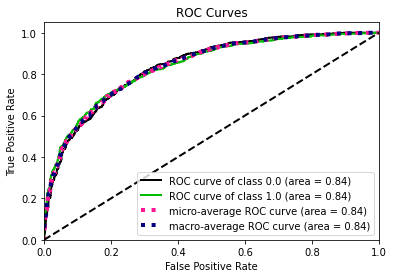

In [ ]:
y_test_proba = clf.predict_proba(X_test_vec)

plot_roc(y_true=y_test, y_probas=y_test_proba)

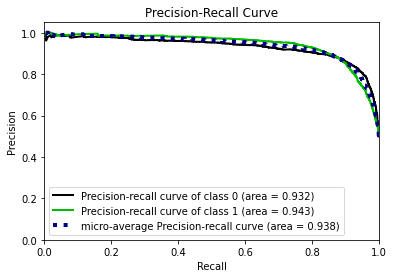

In [ ]:
plot_precision_recall(y_true=df_train['y'], y_probas=y_train_proba)

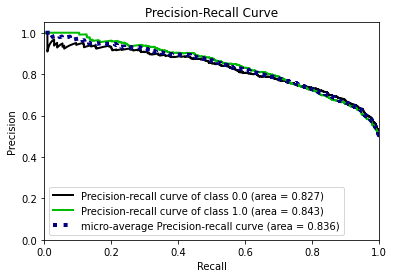

In [ ]:
plot_precision_recall(y_true=y_test, y_probas=y_test_proba)

In [ ]:
test_tweet = ['very good movie :)']
test_twitter_vec = vectorizer.transform(test_tweet)
test_pred = clf.predict(test_twitter_vec)
if test_pred == 0:
  print("Tweet o sentymencie negatywnym")
else:
  print("Tweet o sentymencie pozytywnym")

Tweet o sentymencie pozytywnym


## Regresja logistyczna #2

In [ ]:
vectorizer_4 = TfidfVectorizer(ngram_range=(1,2), max_features=25000, encoding="utf-8", stop_words=stopwords.words('english'))
vectorizer_4.fit(X_train_norm)

X_train_vec_4 = vectorizer_4.transform(df_train['X'])
X_train_vec_4

<8000x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 61301 stored elements in Compressed Sparse Row format>

In [ ]:
clf_2 = LogisticRegression()
clf_2.fit(X_train_vec_4, df_train['y'])

LogisticRegression()

In [ ]:
y_train_pred_4 = clf_2.predict(X_train_vec_4)

print('Train acc: ', accuracy_score(y_true=df_train['y'], y_pred=y_train_pred_4))
print('Train precision: ', precision_score(y_true=df_train['y'], y_pred=y_train_pred_4))
print('Train recall: ', recall_score(y_true=df_train['y'], y_pred=y_train_pred_4))

Train acc:  0.913375
Train precision:  0.9373181697963502
Train recall:  0.886


In [ ]:
X_test_vec_4 = vectorizer_4.transform(X_test_norm)
y_test_pred_4 = clf_2.predict(X_test_vec_4)

print('Test acc: ', accuracy_score(y_true=y_test, y_pred=y_test_pred_4))
print('Test precision: ', precision_score(y_true=y_test, y_pred=y_test_pred_4))
print('Test recall: ', recall_score(y_true=y_test, y_pred=y_test_pred_4))

Test acc:  0.743
Test precision:  0.7832167832167832
Test recall:  0.672


## SimpleRNN


In [ ]:
vectorizer_2 = TfidfVectorizer(ngram_range=(1,1), max_features=1000)
vectorizer_2.fit(df_train['X'])

X_train_vec_arr = vectorizer_2.transform(df_train['X']).toarray()
X_test_vec_arr = vectorizer_2.transform(X_test_norm).toarray()

X_train_vec_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print(X_train_vec_arr.shape)
print(X_test_vec_arr.shape)

(8000, 1000)
(2000, 1000)


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)

[0. 1.] [4000 4000]


In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0. 1000.]
 [   1. 1000.]]


In [ ]:
from keras.layers import Flatten

In [ ]:
from keras.layers import Dense
from keras.layers import SimpleRNN, Dropout, Embedding
from keras.models import Sequential


model = Sequential()
model.add(Embedding(1000, 16))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(16))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 16)          16000     
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, None, 32)          1568      
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, None, 64)          6208      
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, None, 32)          3104      
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 16)                784       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 27,681
Trainable params: 27,681
Non-tra

In [ ]:
from traitlets.traitlets import validate

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_vec_arr, y_train, epochs=5, batch_size=128, validation_split=0.20)

Epoch 1/5
50/50 [==============================] - 147s 3s/step - loss: 0.6719 - acc: 0.6212 - val_loss: 1.0941 - val_acc: 0.0000e+00
Epoch 2/5
50/50 [==============================] - 144s 3s/step - loss: 0.6647 - acc: 0.6250 - val_loss: 0.9229 - val_acc: 0.0000e+00
Epoch 3/5
50/50 [==============================] - 145s 3s/step - loss: 0.6633 - acc: 0.6250 - val_loss: 1.0150 - val_acc: 0.0000e+00
Epoch 4/5
50/50 [==============================] - 144s 3s/step - loss: 0.6622 - acc: 0.6250 - val_loss: 0.8782 - val_acc: 0.0000e+00
Epoch 5/5
50/50 [==============================] - 144s 3s/step - loss: 0.6628 - acc: 0.6250 - val_loss: 0.9809 - val_acc: 0.0000e+00


In [ ]:
vectorizer_3 = TfidfVectorizer(ngram_range=(1,2), max_features=100, stop_words=stopwords.words('english'))
vectorizer_3.fit(df_train['X'])

X_train_vec_arr = vectorizer_3.transform(df_train['X']).toarray()
X_test_vec_arr = vectorizer_3.transform(X_test_norm).toarray()

print(X_train_vec_arr.shape)
print(X_test_vec_arr.shape)

(8000, 100)
(2000, 100)


In [ ]:
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(100, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Dropout(0.4))
model.add(SimpleRNN(32, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['acc'])
history_2 = model.fit(X_train_vec_arr, y_train, epochs=15, batch_size=16, validation_split=0.20)

## Osadzanie słów

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 50
max_features = 1000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['X'])
sequences = tokenizer.texts_to_sequences(df_train['X'])

print(f'Liczba unikatowych tokentów: {len(tokenizer.word_index)}')

Liczba unikatowych tokentów: 11475


In [ ]:
len(sequences)

8000

In [ ]:
train_data = pad_sequences(sequences, maxlen=max_words)
train_labels = np.asarray(y_train)

print(f'Kształt X_train: {train_data.shape}')
print(f'Kształt y_train: {train_labels.shape}')

Kształt X_train: (8000, 50)
Kształt y_train: (8000,)


Osadzenia słów GloVe:

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-08-28 09:57:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-28 09:57:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-28 09:57:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Znaleziono %s wektorów słów.' % len(embeddings_index))

Znaleziono 400000 wektorów słów.


Budowanie macierzy osadzeń:

In [ ]:
embedding_dim = 50
max_features

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:
            # Słowa nieznalezione w osadzanym indeksie zostaną zastąpione zerami.
            embedding_matrix[i] = embedding_vector

Definiowanie modelu:

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_words))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 50, 50)            50000     
                                                                 
 flatten_26 (Flatten)        (None, 2500)              0         
                                                                 
 dense_133 (Dense)           (None, 64)                160064    
                                                                 
 dense_134 (Dense)           (None, 64)                4160      
                                                                 
 dense_135 (Dense)           (None, 32)                2080      
                                                                 
 dense_136 (Dense)           (None, 32)                1056      
                                                                 
 dense_137 (Dense)           (None, 32)              

In [ ]:
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_data, train_labels, epochs=60, batch_size=128, validation_split=0.2)

Epoch 1/60
50/50 [==============================] - 1s 8ms/step - loss: 0.6756 - acc: 0.6166 - val_loss: 0.9363 - val_acc: 0.0000e+00
Epoch 2/60
50/50 [==============================] - 0s 4ms/step - loss: 0.6627 - acc: 0.6250 - val_loss: 0.9500 - val_acc: 0.0000e+00
Epoch 3/60
50/50 [==============================] - 0s 4ms/step - loss: 0.6606 - acc: 0.6250 - val_loss: 0.9544 - val_acc: 0.0000e+00
Epoch 4/60
50/50 [==============================] - 0s 4ms/step - loss: 0.6578 - acc: 0.6250 - val_loss: 0.9625 - val_acc: 0.0000e+00
Epoch 5/60
50/50 [==============================] - 0s 4ms/step - loss: 0.6552 - acc: 0.6266 - val_loss: 1.0096 - val_acc: 0.0000e+00
Epoch 6/60
50/50 [==============================] - 0s 4ms/step - loss: 0.6504 - acc: 0.6283 - val_loss: 0.9573 - val_acc: 0.0250
Epoch 7/60
50/50 [==============================] - 0s 4ms/step - loss: 0.6447 - acc: 0.6350 - val_loss: 0.9635 - val_acc: 0.0800
Epoch 8/60
50/50 [==============================] - 0s 4ms/step - loss

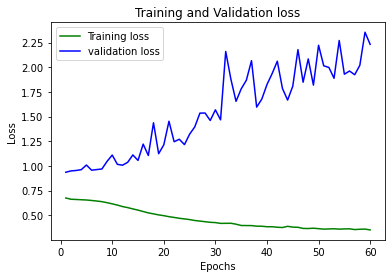

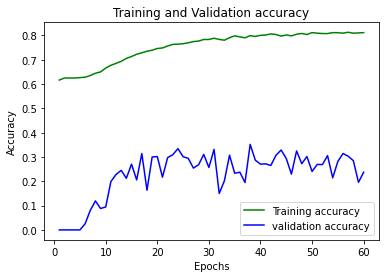

In [ ]:
import matplotlib.pyplot as plt

def loss_visualisation(history):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = np.arange(1, len(history.history['acc'])+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def acc_visualisation(history):
  acc_train = history.history['acc']
  acc_val = history.history['val_acc']
  epochs = np.arange(1, len(history.history['acc'])+1)
  plt.plot(epochs, acc_train, 'g', label='Training accuracy')
  plt.plot(epochs, acc_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

loss_visualisation(history)
acc_visualisation(history)

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_words))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False
model.summary()

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['acc'])
history_4 = model.fit(train_data, train_labels, epochs=60, batch_size=64, validation_split=0.2)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 50, 50)            50000     
                                                                 
 flatten_19 (Flatten)        (None, 2500)              0         
                                                                 
 dense_92 (Dense)            (None, 128)               320128    
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_93 (Dense)            (None, 128)               16512     
                                                                 
 dense_94 (Dense)            (None, 256)               33024     
                                                                 
 dropout_19 (Dropout)        (None, 256)             

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_words))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16))
model.add(Dense(16, activation='relu'))
model.add(Dense(16))
model.add(Dense(16, activation='relu'))
model.add(Dense(16))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False
model.summary()

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['acc'])
history_4 = model.fit(train_data, train_labels, epochs=60, batch_size=16, validation_split=0.2)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 50, 50)            50000     
                                                                 
 flatten_20 (Flatten)        (None, 2500)              0         
                                                                 
 dense_100 (Dense)           (None, 16)                40016     
                                                                 
 dense_101 (Dense)           (None, 16)                272       
                                                                 
 dense_102 (Dense)           (None, 16)                272       
                                                                 
 dense_103 (Dense)           (None, 16)                272       
                                                                 
 dense_104 (Dense)           (None, 16)              

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_words))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False
model.summary()

model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
history_5 = model.fit(train_data, train_labels, epochs=60, batch_size=64, validation_split=0.2)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 50, 50)            50000     
                                                                 
 flatten_21 (Flatten)        (None, 2500)              0         
                                                                 
 dense_108 (Dense)           (None, 128)               320128    
                                                                 
 dense_109 (Dense)           (None, 256)               33024     
                                                                 
 dense_110 (Dense)           (None, 512)               131584    
                                                                 
 dense_111 (Dense)           (None, 32)                16416     
                                                                 
 dense_112 (Dense)           (None, 1)               

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_words))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False
model.summary()

model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
history_5 = model.fit(train_data, train_labels, epochs=100, batch_size=124, validation_split=0.3)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 50, 50)            50000     
                                                                 
 flatten_24 (Flatten)        (None, 2500)              0         
                                                                 
 dense_120 (Dense)           (None, 256)               640256    
                                                                 
 dense_121 (Dense)           (None, 256)               65792     
                                                                 
 dense_122 (Dense)           (None, 256)               65792     
                                                                 
 dense_123 (Dense)           (None, 256)               65792     
                                                                 
 dense_124 (Dense)           (None, 1)               

## Analiza tweetów

Źródło: https://www.kaggle.com/datasets/mrmorj/us-politicians-twitter-dataset/code

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kaushiksuresh147/political-tweets

 45% 17.0M/37.5M [00:00<00:00, 64.7MB/s]
100% 37.5M/37.5M [00:00<00:00, 121MB/s] 


In [ ]:
! unzip political-tweets

Archive:  political-tweets.zip
  inflating: Political_tweets.csv    


In [ ]:
dataset = pd.read_csv("/content/Political_tweets.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
dataset.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,CPA Jim 2021,NaN,Grandparents enslaved by CCP since 1949 were b...,2011-03-17 10:17:36,711.0,146.0,1160.0,False,2021-07-30 23:57:05,US says seizes tanker used to evade North Kore...,"['politics', 'feedly']",Twitter Web App,False
1,Joint Minds,NaN,Joint Minds Podcast,2021-01-23 23:57:27,3.0,3.0,1.0,False,2021-07-30 23:53:21,Is America the greatest country? Part 1 drops ...,"['america', 'jointminds', 'politics', 'democra...",Twitter for iPhone,False
2,Sociafy,USA,Sociafy is an influencer-based content discove...,2011-09-30 05:59:06,36219.0,181.0,930.0,False,2021-07-30 23:53:03,O’Reilly predicts THIS is What DOOMS Biden’s r...,"['politics', 'videos']",Buffer,False
3,🟣 Discussions.app,United States,Home of Crypto Communities. $ATMOS \n\nhttps:/...,2017-02-09 23:15:24,2426.0,1104.0,8173.0,False,2021-07-30 23:51:00,Corruption in Politics\n#blog #politics \nhttp...,"['blog', 'politics']",TweetDeck,False
4,Ground News,"Kitchener, ON",The world's first news source comparison platf...,2018-02-08 22:00:16,13763.0,1224.0,2033.0,False,2021-07-30 23:50:53,@kylegriffin1 Are you getting all the info on ...,"['EvictionMoratorium', 'Congress', 'NancyPelos...",GroundNews,False


In [ ]:
test_tweets = dataset['text'].tolist()

In [ ]:
test_tweets[:5]

['US says seizes tanker used to evade North Korea sanctions https://t.co/ABaaAcIUnr #politics #feedly',
 'Is America the greatest country? Part 1 drops 8/3 @ 10 am PST. Link:  https://t.co/jkXYrAOSuD\n#america #jointminds #politics #democracy #communism #capitalism #podcast https://t.co/8sNTqhSPnT',
 'O’Reilly predicts THIS is What DOOMS Biden’s reelection chance - via: @glennbeck https://t.co/VHWiJWEK48 #politics #videos https://t.co/A1KLPNWfEU',
 'Corruption in Politics\n#blog #politics \nhttps://t.co/beV97ub2H2',
 "@kylegriffin1 Are you getting all the info on #EvictionMoratorium? If you read Politico , don't miss out on what 19 other sources have to say #Congress #NancyPelosi #Politics #DemocraticParty https://t.co/i3SDI3s3F8"]

In [ ]:
test_tweets_norm = [process_tweet(x) for x in test_tweets]
test_tweets_norm[:5]

['us says seizes tanker used to evade north korea sanctions  ',
 'is america the greatest country? part 1 drops 8/3 @ 10 am pst. link:   america jointminds politics democracy communism capitalism podcast  ',
 'o’reilly predicts this is what dooms biden’s reelection chance - via:    ',
 'corruption in politics blog politics   ',
 "  are you getting all the info on evictionmoratorium? if you read politico , don't miss out on what 19 other sources have to say congress nancypelosi politics democraticparty  "]

In [ ]:
test_tweets_vec = vectorizer.transform(test_tweets_norm)
test_tweets_pred = clf.predict(test_tweets_vec)

In [ ]:
df_test_tweets = pd.DataFrame(
    {'Tweets': test_tweets_norm, 'Sentiment':test_tweets_pred.astype(int)}
)

In [ ]:
df_test_tweets.sample(40)

,Tweets,Sentiment
223759,in rabi marketing season 2022-23 quantity of ...,1
44840,peruvian president reports of agreement on dom...,1
76649,scotland sets out £100m hydrogen plan,1
238517,shreveport will receive million for improvem...,1
83322,"hopefully optimistic! however, this is polit...",0
70953,multilingual news service hindi 04 november 21...,1
88626,homeserve steams ahead with heat pump drive ne...,1
184148,i do not know who needs to hear this but... do...,0
210706,i would suck bill clinton’s dick for a klondik...,1
84660,apga leads in awka south - anambra election -,1
